In [2]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from database import DB

In [90]:
db = DB()
db.initialise()

temp_df = db.get_table('view_set_match_info_concat')

In [151]:
temp_df

,league_name,year,season,date,set_number,team_1,team_2,corresponding_team,tiebreaker,match_round,...,team_minion_kills,team_monster_kills,team_goldat10,team_goldat15,team_golddiffat10,team_golddiffat15,team_csat10,team_csat15,team_csdiffat10,team_csdiffat15
0,BL,2020,spring,2020-01-21,1,Sector One,Aethra,Sector One,0,1,...,640.0,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BL,2020,spring,2020-01-21,1,Brussels Guardians,KV Mechelen,Brussels Guardians,0,1,...,911.0,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BL,2020,spring,2020-01-21,1,Brussels Guardians,RSCA,Brussels Guardians,0,1,...,651.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BL,2020,spring,2020-01-21,1,Sector One,Timeout Esports,Sector One,0,1,...,751.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BL,2020,spring,2020-01-21,1,Sector One,Timeout Esports,Timeout Esports,0,1,...,719.0,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35687,VCS,2020,summer,2020-08-16,1,Saigon Buffalo,EVOS Esports,Saigon Buffalo,0,9,...,816.0,201.0,15057.0,24696.0,-2406.0,-1941.0,311.0,488.0,-33.0,-49.0
35688,VCS,2020,summer,2020-08-16,2,Percent Esports,OverPower Esports,Percent Esports,0,9,...,806.0,182.0,15132.0,24154.0,-1202.0,-1576.0,321.0,506.0,-15.0,-18.0
35689,VCS,2020,summer,2020-08-16,2,Saigon Buffalo,EVOS Esports,Saigon Buffalo,0,9,...,556.0,111.0,13726.0,22834.0,-5458.0,-8690.0,256.0,416.0,-31.0,-75.0
35690,VCS,2020,summer,2020-08-16,2,Percent Esports,OverPower Esports,OverPower Esports,0,9,...,778.0,240.0,16334.0,25730.0,1202.0,1576.0,336.0,524.0,15.0,18.0


In [165]:
df = temp_df[['league_name', 'year', 'season', 'date', 'set_number', 'team_1', 'team_2', 'corresponding_team', 'tiebreaker', 'match_round', 'wdl', 'side', 'team_kills', 'team_deaths', 'team_dragon_kills', 'team_total_gold']]
df = df.dropna(subset=['wdl', 'side'])

In [168]:
cat_cols = ['side']
cont_cols = ['team_kills', 'team_deaths', 'team_dragon_kills', 'team_total_gold']
y_col = ['wdl']
# df = pd.get_dummies(df, columns=y_col, drop_first=True)
# df = df.rename(columns={'wdl_W':'wdl'})
df[y_col] = df[y_col].astype('category')
y = np.stack([df[col].cat.codes.values for col in y_col], 1)
y = torch.tensor(y, dtype=torch.long).flatten()

for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    
# redBlue = df['side'].cat.codes.values
# cats = np.stack([redBlue], 1)

cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64)

conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)



In [169]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
nn.ModuleList([nn.Embedding(i, f) for i, f in emb_szs])

ModuleList(
  (0): Embedding(2, 1)
)

In [170]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(i,f) for i, f in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_count = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum((f for i,f in emb_szs))
        n_input = n_emb + n_cont
        
        for i in layers:
            layer_list.append(nn.Linear(n_input, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_input = i
        layer_list.append(nn.Linear(layers[-1], out_sz)) # output layer
        self.layer = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_count(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layer(x)
        return nn.Softmax(dim=1)(x)

In [171]:
torch.manual_seed(69)
model = TabularModel(emb_szs, conts.shape[1], 2, [200, 100], p=0.5)

In [172]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [173]:
#batch_size = temp_df.shape[0]
train_size = temp_df[temp_df['year']!=2020].shape[0]
val_size = temp_df[temp_df['year']==2020].shape[0] // 2
test_size = temp_df[temp_df['year']==2020].shape[0] // 2

cat_train = cats[:train_size]
con_train = conts[:train_size]
y_train = y[:train_size]

cat_valid = cats[train_size: train_size+val_size]
con_valid = conts[train_size: train_size+val_size]
y_valid = y[train_size: train_size+val_size]

cat_test = cats[train_size+val_size: train_size+val_size+test_size]
con_test = conts[train_size+val_size: train_size+val_size+test_size]
y_test = y[train_size+val_size: train_size+val_size+test_size]

In [174]:
import time
start_time = time.time()

epochs = 300
costs = []

for epoch in range(epochs):
    y_pred = model.forward(cat_train, con_train)
    cost = criterion(y_pred, y_train)
    costs.append(cost)
    
    if epoch % 25 == 0:
        print(f'epoch: {epoch}, cost: {cost:.8f}')
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print(f'Duration: {(time.time() - start_time):.0f} seconds')

epoch: 0, cost: 0.71765983
epoch: 25, cost: 0.37575829
epoch: 50, cost: 0.36751997
epoch: 75, cost: 0.36334005
epoch: 100, cost: 0.36243507
epoch: 125, cost: 0.36093074
epoch: 150, cost: 0.36133480
epoch: 175, cost: 0.35993585
epoch: 200, cost: 0.35957569
epoch: 225, cost: 0.35907561
epoch: 250, cost: 0.35896492
epoch: 275, cost: 0.35817498
Duration: 151 seconds


Text(0.5, 0, 'epoch')

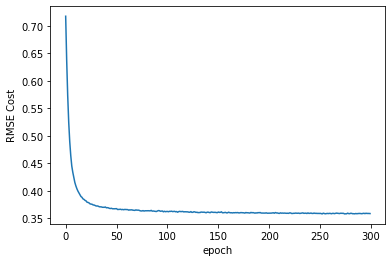

In [175]:
plt.plot(range(epochs), costs)
plt.ylabel('RMSE Cost')
plt.xlabel('epoch')

In [176]:
with torch.no_grad():
    y_pred = model(cat_test, con_test)
    cost = criterion(y_pred, y_test)
print(f'CE Loss: {cost:.8f}')
    

CE Loss: 0.35097960


In [177]:
rows = 50
correct = 0
print(f'{"Model output":36} ARGMAX    Y_test')
for i in range(rows):
    print(f'{str(y_pred[i]):36}  {y_pred[i].argmax():^7}{y_test[i]:^7}')
    if y_pred[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

Model output                         ARGMAX    Y_test
tensor([9.9993e-01, 7.2358e-05])         0      0   
tensor([1.0000e+00, 1.5345e-06])         0      0   
tensor([1.0000e+00, 1.7814e-07])         0      0   
tensor([2.9808e-05, 9.9997e-01])         1      1   
tensor([9.9998e-01, 1.7624e-05])         0      0   
tensor([9.3959e-07, 1.0000e+00])         1      1   
tensor([1.3498e-04, 9.9987e-01])         1      1   
tensor([0.0051, 0.9949])                 1      1   
tensor([9.9993e-01, 7.4103e-05])         0      0   
tensor([5.1702e-05, 9.9995e-01])         1      1   
tensor([2.6135e-06, 1.0000e+00])         1      1   
tensor([3.7764e-06, 1.0000e+00])         1      1   
tensor([9.9995e-01, 5.2985e-05])         0      0   
tensor([9.9993e-01, 6.8805e-05])         0      0   
tensor([3.1764e-07, 1.0000e+00])         1      1   
tensor([0.9495, 0.0505])                 0      0   
tensor([4.0908e-07, 1.0000e+00])         1      1   
tensor([9.9999e-01, 1.4683e-05])         0   